# Train NNs for standard NN - 0-week
## All other weeks substituted out in settings file

In [46]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Marybeth Arcodia 
"""
import numpy as np
import random
import xarray as xr
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import math

from sklearn import preprocessing
import tensorflow as tf

import import_ipynb
import sys
import os 

import network_arch as network
import metrics
import plot as plot
import settings
import functions_misc as fnc


from cartopy import config
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import pop_tools


In [47]:
EXPERIMENT = 'exp_0/exp_000'

#directories need to be specified

ddir_X = 
ddir_Y = 
ddir_out = 
ddir_MODEL = ddir_out
ddir_saveinfo = 

params = settings.get_settings(EXPERIMENT)

PREDICTOR_VAR  = params['PREDICTOR_VAR']           
PREDICTAND_VAR = params['PREDICTAND_VAR']              
REGION_TOR     = params['REGION_TOR']          
REGION_TAND    = params['REGION_TAND']            
training_ens   = params['training_ens']            
validation_ens = params['validation_ens']           
testing_ens    = params['testing_ens']           
train_list     = params['train_list']
val_list       = params['val_list']
lead           = params['lead']            
days_average   = params['days_average']            
GLOBAL_SEED    = params['GLOBAL_SEED']            
HIDDENS        = params['HIDDENS']          
DROPOUT        = params['DROPOUT']            
RIDGE1         = params['RIDGE1']                    
LR_INIT        = params['LR_INIT']
BATCH_SIZE     = params['BATCH_SIZE']           
RANDOM_SEED    = params['RANDOM_SEED']            
act_fun        = params['act_fun']            
N_EPOCHS       = params['N_EPOCHS']           
PATIENCE       = params['PATIENCE']   
CLASS_WEIGHT   = 'none'

window_size = days_average
testing_ens

0

In [48]:
lead_weeks = int(lead/7)
lead_weeks

0

In [49]:
rolling_input_window_X = 3
rolling_input_window_Y = 1

In [50]:
def is_mam(month):
    return np.logical_and(month>=3, month<=5)

def is_may(month):
    return np.logical_and(month>=5, month<=5)

def is_aug(month):
    return np.logical_and(month>=8, month<=8)

#>>>>>SET UP <<<<<<<<<<<<<<<
np.random.seed(GLOBAL_SEED)
random.seed(GLOBAL_SEED)
tf.compat.v1.random.set_random_seed(GLOBAL_SEED)

NLABEL = 2

YEARS = '1850-1949'
STRT_I = pd.to_datetime('01-01-1850')
END_I   = pd.to_datetime('12-31-1949')  + dt.timedelta(days=1)

time_range = xr.cftime_range(str(STRT_I)[:10], str(END_I)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
#time_range_szn = time_range.where(fnc.is_mjja(time_range.month)).dropna()
TIME_ALL = xr.DataArray(time_range + dt.timedelta(days=0), dims=['time'])     

STRT_2 = pd.to_datetime('05-01-1850')
END_2   = pd.to_datetime('08-31-1949')  + dt.timedelta(days=1)
time_range2 = xr.cftime_range(str(STRT_2)[:10], str(END_2)[:10],calendar = 'noleap') #[0:10] corresponds to full datestamp
time_range_2 = time_range2.where(fnc.is_mjja(time_range2.month)).dropna()
TIME_X = xr.DataArray(time_range_2 + dt.timedelta(days=0), dims=['time'])   

TIME_Y = xr.DataArray(time_range_2 + dt.timedelta(days=lead+days_average), dims=['time'])  


In [51]:
# ----- X TRAINING ------
min_lon = 265 
min_lat = 8 
max_lon = 320 
max_lat = 50 

count = 0 
for i in train_list:
    X_finame = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+i+'_dailyanom_detrend.nc'
    X_all_full = xr.open_dataarray(ddir_X+X_finame)
    X1 = X_all_full.where(X_all_full.time == TIME_ALL, drop=True)
    X = X1.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    
    X_nptime = np.array(X.time)                 
    X_nplat = np.array(X.lat)
    X_nplon = np.array(X.lon)
    del X_all_full 

    if count == 0: # don't rewrite empty matrix each time 
        X_all1_FULL = xr.DataArray(np.zeros((len(train_list),X.shape[0],X.shape[1],X.shape[2]))+np.nan,
                             dims = ['ens','time','lat','lon'],
                             coords = [('ens',np.arange(0,len(train_list))),('time', X_nptime),('lat',X_nplat),('lon',X_nplon)])

    X_all1_FULL[count,:,:,:] = X   
    
    count = count+1
    del X

X_all1_ROLL = X_all1_FULL.rolling(time=(rolling_input_window_X),center=False).mean()
X_all1_inputtime1 = X_all1_ROLL.where(X_all1_ROLL.time == TIME_X, drop=True)
X_all1_inputtime = X_all1_inputtime1.dropna(dim='time', how = 'all')

Xtrain1 = X_all1_inputtime.stack(time_all=('ens','time')) # lat,lon,time*8 (8= number of training ens members) 
Xtrain1 = Xtrain1.transpose('time_all','lat','lon') # time*8,lat,lon
Xtrain_std1 = np.std(Xtrain1,axis=0)
Xtrain_mean1 = np.mean(Xtrain1,axis=0)
Xtrain_full = (Xtrain1-Xtrain_mean1)/Xtrain_std1


del X_all1_ROLL, X_all1_inputtime1, X1, Xtrain1

/Users/marcodia/opt/anaconda3/envs/tf2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


## Apply Mask

In [52]:
# Define latitude and longitude ranges that correspond to the Pacific Ocean
pacific_lat_range = slice(0, 3)  # Adjust the latitudes 
pacific_lon_range = slice(0, 5)  # Adjust the longitudes 

# Create a mask for the Pacific Ocean
mask = np.zeros(Xtrain_full.shape[1:], dtype=bool)
mask[pacific_lat_range, pacific_lon_range] = True

# Expand the mask to match the 'time' dimension
mask_expanded = np.repeat(mask[None, :, :], len(Xtrain_full.time_all), axis=0)

# Apply the mask 
Xtrain = Xtrain_full.where(~mask_expanded, np.nan)

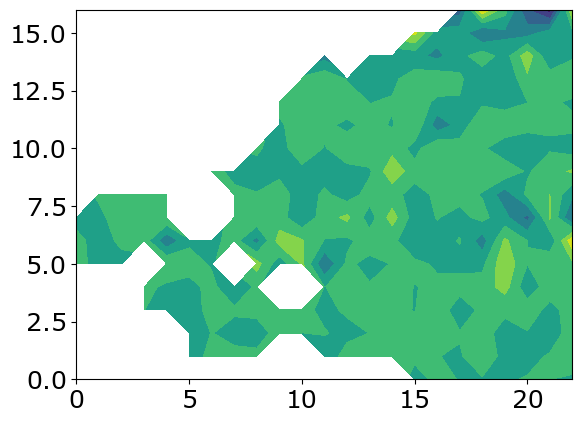

In [53]:
plt.contourf(np.mean(Xtrain,axis=0))

In [54]:
# ---------- X VALIDATION----------
count = 0 
for i in val_list:
    X_finame = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+i+'_dailyanom_detrend.nc'
    X_all_full = xr.open_dataarray(ddir_X+X_finame)
    X1 = X_all_full.where(X_all_full.time == TIME_ALL, drop=True)
    X = X1.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))
    
    X_nptime = np.array(X.time)                 
    X_nplat = np.array(X.lat)
    X_nplon = np.array(X.lon)
    del X_all_full 

    if count == 0: # don't rewrite empty matrix each time 
        X_val1_FULL = xr.DataArray(np.zeros((len(val_list),X.shape[0],X.shape[1],X.shape[2]))+np.nan,
                             dims = ['ens','time','lat','lon'],
                             coords = [('ens',np.arange(0,len(val_list))),('time', X_nptime),('lat',X_nplat),('lon',X_nplon)])

    X_val1_FULL[count,:,:,:] = X   
    
    count = count+1
    del X

X_val1_ROLL = X_val1_FULL.rolling(time=(rolling_input_window_X),center=False).mean()
X_val1_inputtime1 = X_val1_ROLL.where(X_val1_ROLL.time == TIME_X, drop=True)
X_val1_inputtime = X_val1_inputtime1.dropna(dim='time', how = 'all')
Xval1 = X_val1_inputtime.stack(time_all=('ens','time')) # lat,lon,time*8 (8= number of training ens members) 
Xval1 = Xval1.transpose('time_all','lat','lon') # time*8,lat,lon

Xval_full = (Xval1 - Xtrain_mean1)/Xtrain_std1

# Create a mask for the Pacific Ocean
mask = np.zeros(Xval_full.shape[1:], dtype=bool)
mask[pacific_lat_range, pacific_lon_range] = True

# Expand the mask to match the 'time' dimension
mask_expanded = np.repeat(mask[None, :, :], len(Xval_full.time_all), axis=0)

# Apply the mask to the dataset
Xval = Xval_full.where(~mask_expanded, np.nan)

In [55]:
# ---------- X TESTING----------
X_finame1  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(testing_ens)+'_dailyanom_detrend.nc'
Xtest1_full = xr.open_dataarray(ddir_X+X_finame1)
Xtest_1= Xtest1_full.where(Xtest1_full.time == TIME_ALL, drop=True)
Xtest1 = Xtest_1.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

X_test1_ROLL = Xtest1.rolling(time=(rolling_input_window_X),center=False).mean()
X_test1_inputtime1 = X_test1_ROLL.where(X_test1_ROLL.time == TIME_X, drop=True)
X_test1_inputtime = X_test1_inputtime1.dropna(dim='time', how = 'all')

Xtest_full = (X_test1_inputtime - Xtrain_mean1)/Xtrain_std1

# Create a mask for the Pacific Ocean
mask = np.zeros(Xtest_full.shape[1:], dtype=bool)
mask[pacific_lat_range, pacific_lon_range] = True

# Expand the mask to match the 'time' dimension
mask_expanded = np.repeat(mask[None, :, :], len(Xtest_full.time), axis=0)

# Apply the mask to the dataset
Xtest = Xtest_full.where(~mask_expanded, np.nan)

In [56]:
del Xtrain_std1, X_test1_inputtime, X_test1_inputtime1, X_test1_ROLL, Xtest1, Xtest_1, Xtest1_full, Xtrain_mean1, X_val1_inputtime, X_val1_ROLL

## Apply Poisson Weighting

In [57]:
lambda_value = [0,7,14,21,28,35,42,49,56,63,70,77,84]
fill_val = np.arange(0,120)

poisson_weights = np.zeros((len(lambda_value),len(fill_val)))
k_lead = 119 

# Calculate Poisson weights for lambda and max value
count = 0
for l in lambda_value:
    poisson_weights[count,:] = fnc.calculate_poisson_weights(l, k_lead)
    count += 1

poisson_weights_T = np.transpose(poisson_weights)

poisson_use = poisson_weights_T[:,lead_weeks]   #THIS NEEDS TO BE SPECIFIED BASED ON LEAD TIME

weight_vector = poisson_use  # Symmetric weights for a centered rolling average

center_element = lead

In [58]:
#%% ----- Y TRAINING--------

count = 0
for i in train_list:
    Ytrain_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_'+YEARS+'_ens'+str(i)+'_'+str(window_size)+'daysum.nc'

    Y_all_full = xr.open_dataarray(ddir_Y+Ytrain_finame)
    Y = Y_all_full.where(Y_all_full.time == TIME_ALL, drop=True)

    Y_nptime = np.array(Y.time)                 
    del Y_all_full 

    if count == 0: # don't rewrite empty matrix each time 
        Y_all = xr.DataArray(np.zeros((len(train_list),Y.shape[0]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(train_list))),('time', Y_nptime)])
        
        poiss_weighted_rolling_avg = xr.DataArray(np.zeros((len(train_list),Y.shape[0]))+np.nan,
                              dims = ['ens','time'],
                            coords = [('ens',np.arange(0,len(train_list))),('time', Y_nptime)])

    Y_all[count,:] = Y   

    centered_weighted_rolling_avg = fnc.uncentered_weighted_rolling_average(Y_all[count,:], weight_vector,center_element)
    poiss_weighted_rolling_avg[count,:] = centered_weighted_rolling_avg   

    count = count + 1

Y_all1_inputtime1 = poiss_weighted_rolling_avg.where(poiss_weighted_rolling_avg.time == TIME_Y, drop=True)
Y_all1_inputtime = Y_all1_inputtime1.dropna(dim='time', how = 'all')
np.arange(Y_all1_inputtime.shape[0])

YP_nptime = np.array(Y_all1_inputtime.time)
Y_all_perc = xr.DataArray(np.zeros((len(train_list),Y_all1_inputtime.shape[1]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(train_list))),('time', YP_nptime)])

for i in np.arange(Y_all1_inputtime.shape[0]):
    heavy_val = np.percentile(Y_all1_inputtime[i,:], 80)
    Y_all_perc[i,:] = (Y_all1_inputtime[i,:] >= heavy_val).astype(int) 

Ytrain = Y_all_perc.stack(time_all=('ens','time'))

# How often does our data fall into each category? This is just for the last ensemble member in training
calcpercent = lambda cat: str((np.sum(np.array(Ytrain) == cat)/len(Ytrain)*100).astype(int))

# Print out the sizes of each class
print('Frequency for each Precip Category')
print('Light: ' + calcpercent(0) + '%')
print('Heavy: ' + calcpercent(1) + '%')

Frequency for each Precip Category
Light: 80%
Heavy: 20%


In [59]:
#%% ----- Y VALIDATION--------

count = 0
for i in val_list:
    Yval_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_'+YEARS+'_ens'+str(i)+'_'+str(window_size)+'daysum.nc'

    Y_all_full = xr.open_dataarray(ddir_Y+Yval_finame)
    Y = Y_all_full.where(Y_all_full.time == TIME_ALL, drop=True)

    Y_nptime = np.array(Y.time)                 
    del Y_all_full 
    
 #   $$$$$$$
    if count == 0: # don't rewrite empty matrix each time 
        Y_all = xr.DataArray(np.zeros((len(val_list),Y.shape[0]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(val_list))),('time', Y_nptime)])
        
        val_poiss_weighted_rolling_avg = xr.DataArray(np.zeros((len(val_list),Y.shape[0]))+np.nan,
                              dims = ['ens','time'],
                            coords = [('ens',np.arange(0,len(val_list))),('time', Y_nptime)])

    Y_all[count,:] = Y   

    val_centered_weighted_rolling_avg = fnc.uncentered_weighted_rolling_average(Y_all[count,:], weight_vector, center_element)
    val_poiss_weighted_rolling_avg[count,:] = val_centered_weighted_rolling_avg   

    count = count + 1

Y_val1_inputtime1 = val_poiss_weighted_rolling_avg.where(val_poiss_weighted_rolling_avg.time == TIME_Y, drop=True)
Y_val1_inputtime = Y_val1_inputtime1.dropna(dim='time', how = 'all')

YP_nptime = np.array(Y_all1_inputtime.time)
Y_val_perc = xr.DataArray(np.zeros((len(val_list),Y_all1_inputtime.shape[1]))+np.nan,
                             dims = ['ens','time'],
                             coords = [('ens',np.arange(0,len(val_list))),('time', YP_nptime)])

for i in np.arange(Y_val1_inputtime.shape[0]):
    heavy_val = np.percentile(Y_val1_inputtime[i,:], 80)
    Y_val_perc[i,:] = (Y_val1_inputtime[i,:] >= heavy_val).astype(int) 

Yval = Y_val_perc.stack(time_all=('ens','time'))
# How often does our data fall into each category? This is just for the last ensemble member in validation
calcpercent = lambda cat: str((np.sum(np.array(Yval) == cat)/len(Yval)*100).astype(int))

# Print out the sizes of each class
print('Frequency for each Precip Category')
print('Light: ' + calcpercent(0) + '%')
print('Heavy: ' + calcpercent(1) + '%')
    

Frequency for each Precip Category
Light: 80%
Heavy: 20%


In [60]:
# ----- Y TESTING --------
Ytest_finame = PREDICTAND_VAR+'_'+REGION_TAND+'_'+YEARS+'_ens'+str(testing_ens)+'_'+str(window_size)+'daysum.nc'

Y_test_full = xr.open_dataarray(ddir_Y+Ytest_finame)
Y = Y_test_full.where(Y_test_full.time == TIME_ALL, drop=True)
Y_nptime = np.array(Y.time)

c_temp = xr.DataArray(np.zeros(Y.shape[0])+np.nan,
                              dims = ['time'],
                            coords = [('time', Y_nptime)])

c_temp[:] = fnc.uncentered_weighted_rolling_average(Y,weight_vector,center_element)

Y_test1_inputtime1 = c_temp.where(c_temp.time == TIME_Y, drop=True)
Y_test1_inputtime = Y_test1_inputtime1.dropna(dim='time', how = 'all')
   
heavy_val = np.percentile(Y_test1_inputtime, 80)
Ytest = (Y_test1_inputtime >= heavy_val).astype(int) 

calcpercent = lambda cat: str((np.sum(np.array(Ytest) == cat)/len(Ytest)*100).astype(int))

# Print out the sizes of each class
print('Frequency for each Precip Category')
print('Light: ' + calcpercent(0) + '%')
print('Heavy: ' + calcpercent(1) + '%')

Frequency for each Precip Category
Light: 80%
Heavy: 20%


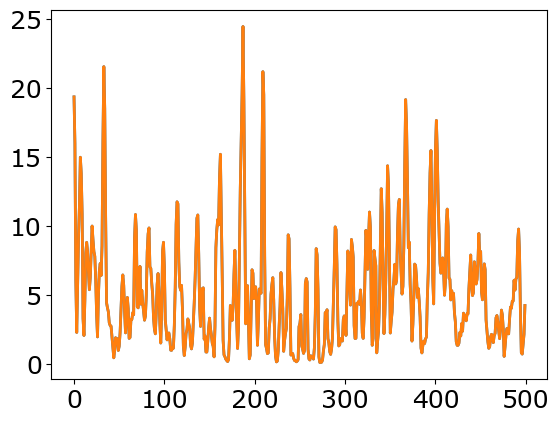

In [61]:
plt.plot(Y[4500:5000])
plt.plot(c_temp[4500:5000])

In [62]:
#Balance Classes
#Training
# make Yval have equal 0s and 1s so that random chance is 50%
n_valzero = np.shape(np.where(Ytrain==0)[0])[0]
n_valone  = np.shape(np.where(Ytrain==1)[0])[0]
i_valzero = np.where(Ytrain==0)[0]
i_valone  = np.where(Ytrain==1)[0]

if n_valone > n_valzero:
    isubset_valone = np.random.choice(i_valone,size=n_valzero,replace=False)
    i_valnew = np.sort(np.append(i_valzero,isubset_valone))
    Y_train_1D = Ytrain.isel(time_all=i_valnew,drop=True)
    X_train_w_NANS  = Xtrain[i_valnew]#.stack(z=('lat','lon'))
elif n_valone < n_valzero:
    isubset_valzero = np.random.choice(i_valzero,size=n_valone,replace=False)
    i_valnew = np.sort(np.append(isubset_valzero,i_valone))
    Y_train_1D = Ytrain.isel(time_all=i_valnew,drop=True)
    X_train_w_NANS  = Xtrain[i_valnew]#.stack(z=('lat','lon'))
else:
    X_train_w_NANS = Xtrain#.stack(z=('lat','lon'))

#Validation
# make Yval have equal 0s and 1s so that random chance is 50%
n_valzero = np.shape(np.where(Yval==0)[0])[0]
n_valone  = np.shape(np.where(Yval==1)[0])[0]
i_valzero = np.where(Yval==0)[0]
i_valone  = np.where(Yval==1)[0]

if n_valone > n_valzero:
    isubset_valone = np.random.choice(i_valone,size=n_valzero,replace=False)
    i_valnew = np.sort(np.append(i_valzero,isubset_valone))
    Y_val_1D = Yval.isel(time_all=i_valnew,drop=True)
    X_val_w_NANS  = Xval[i_valnew]#.stack(z=('lat','lon'))
elif n_valone < n_valzero:
    isubset_valzero = np.random.choice(i_valzero,size=n_valone,replace=False)
    i_valnew = np.sort(np.append(isubset_valzero,i_valone))
    Y_val_1D = Yval.isel(time_all=i_valnew,drop=True)
    X_val_w_NANS  = Xval[i_valnew]#.stack(z=('lat','lon'))
else:
    X_val_w_NANS = Xval#.stack(z=('lat','lon'))
    
#Testing
# make Ytest have equal 0s and 1s so that random chance is 50%
n_valzero = np.shape(np.where(Ytest==0)[0])[0]
n_valone  = np.shape(np.where(Ytest==1)[0])[0]
i_valzero = np.where(Ytest==0)[0]
i_valone  = np.where(Ytest==1)[0]

if n_valone > n_valzero:
    isubset_valone = np.random.choice(i_valone,size=n_valzero,replace=False)
    i_valnew = np.sort(np.append(i_valzero,isubset_valone))
    Y_test_1D = Ytest.isel(time=i_valnew,drop=True)
    X_test_w_NANS  = Xtest[i_valnew]#.stack(z=('lat','lon'))
elif n_valone < n_valzero:
    isubset_valzero = np.random.choice(i_valzero,size=n_valone,replace=False)
    i_valnew = np.sort(np.append(isubset_valzero,i_valone))
    Y_test_1D = Ytest.isel(time=i_valnew,drop=True)
    X_test_w_NANS  = Xtest[i_valnew]#.stack(z=('lat','lon'))
else:
    X_test_w_NANS = Xtest#.stack(z=('lat','lon'))

In [63]:
X_train_stack = X_train_w_NANS.stack(z=('lat','lon'))
X_train = X_train_stack.dropna(dim="z", how="any")

X_val_stack = X_val_w_NANS.stack(z=('lat','lon'))
X_val = X_val_stack.dropna(dim="z", how="any")

X_test_stack = X_test_w_NANS.stack(z=('lat','lon'))
X_test = X_test_stack.dropna(dim="z", how="any")

enc = preprocessing.OneHotEncoder()
Y_train      = enc.fit_transform(np.array(Y_train_1D).reshape(-1, 1)).toarray()
Y_val  = enc.fit_transform(np.array(Y_val_1D).reshape(-1, 1)).toarray()
Y_test  = enc.fit_transform(np.array(Y_test_1D).reshape(-1, 1)).toarray()

In [64]:
X_train.shape

(34440, 265)

In [65]:
Y_train_1D.shape

(34440,)

In [66]:
Y_val.shape

(9840, 2)

In [67]:
X_test.unstack().lon

<xarray.DataArray 'lon' (lon: 23)>
array([265. , 267.5, 270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5,
       290. , 292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. , 312.5,
       315. , 317.5, 320. ])
Coordinates:
  * lon      (lon) float64 265.0 267.5 270.0 272.5 ... 312.5 315.0 317.5 320.0

In [68]:
Y_test_1D.time

<xarray.DataArray 'time' (time: 4920)>
array([cftime.DatetimeNoLeap(1850, 5, 7, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 5, 12, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1850, 5, 16, 0, 0, 0, 0, has_year_zero=True), ...,
       cftime.DatetimeNoLeap(1949, 8, 29, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 8, 30, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1949, 9, 3, 0, 0, 0, 0, has_year_zero=True)],
      dtype=object)
Coordinates:
  * time     (time) object 1850-05-07 00:00:00 ... 1949-09-03 00:00:00

In [69]:
Xval1.lon

<xarray.DataArray 'lon' (lon: 23)>
array([265. , 267.5, 270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5,
       290. , 292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. , 312.5,
       315. , 317.5, 320. ])
Coordinates:
  * lon      (lon) float64 265.0 267.5 270.0 272.5 ... 312.5 315.0 317.5 320.0

In [70]:
X_test.unstack().lon

<xarray.DataArray 'lon' (lon: 23)>
array([265. , 267.5, 270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5,
       290. , 292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. , 312.5,
       315. , 317.5, 320. ])
Coordinates:
  * lon      (lon) float64 265.0 267.5 270.0 272.5 ... 312.5 315.0 317.5 320.0

In [71]:
ddir_out

'/Users/marcodia/Research/salinity_s2s/experiments/no_arctic/exp_0/'

In [72]:
del Y_val1_inputtime, Yval, Y_val1_inputtime1, Ytrain

In [73]:
del X_val1_inputtime1, X_all1_inputtime

In [74]:
del val_centered_weighted_rolling_avg, centered_weighted_rolling_avg

# Train NNs

In [75]:
# # MAKE THE NN ARCHITECTURE
def make_model():
    # Define and train the model
    tf.keras.backend.clear_session()
    model = network.defineNN(HIDDENS,
                             input1_shape = X_train.shape[1],
                             output_shape=NLABEL,
                             ridge_penalty1=RIDGE1,
                             dropout=DROPOUT,
                             act_fun='relu',
                             network_seed=NETWORK_SEED)
    
    loss_function = tf.keras.losses.CategoricalCrossentropy()    
    model.compile(
                  optimizer = tf.keras.optimizers.Adam(learning_rate=LR_INIT),
                  loss = loss_function,
                  metrics = [
                      tf.keras.metrics.CategoricalAccuracy(name="categorical_accuracy", dtype=None),
                      metrics.PredictionAccuracy(NLABEL)
                      ]
                  )           
    return model, loss_function

6
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 265)]             0         
                                                                 
 dropout (Dropout)           (None, 265)               0         
                                                                 
 dense (Dense)               (None, 128)               34048     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,306
Trainable params: 34,306
Non-trainable params: 0
_________________________________________________________________
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 265

2023-09-07 19:53:24.408727: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Restoring model weights from the end of the best epoch: 176.
Epoch 201: early stopping
308/308 [==============================] - 1s 2ms/step
Elapsed time during fit = 2097.96 seconds



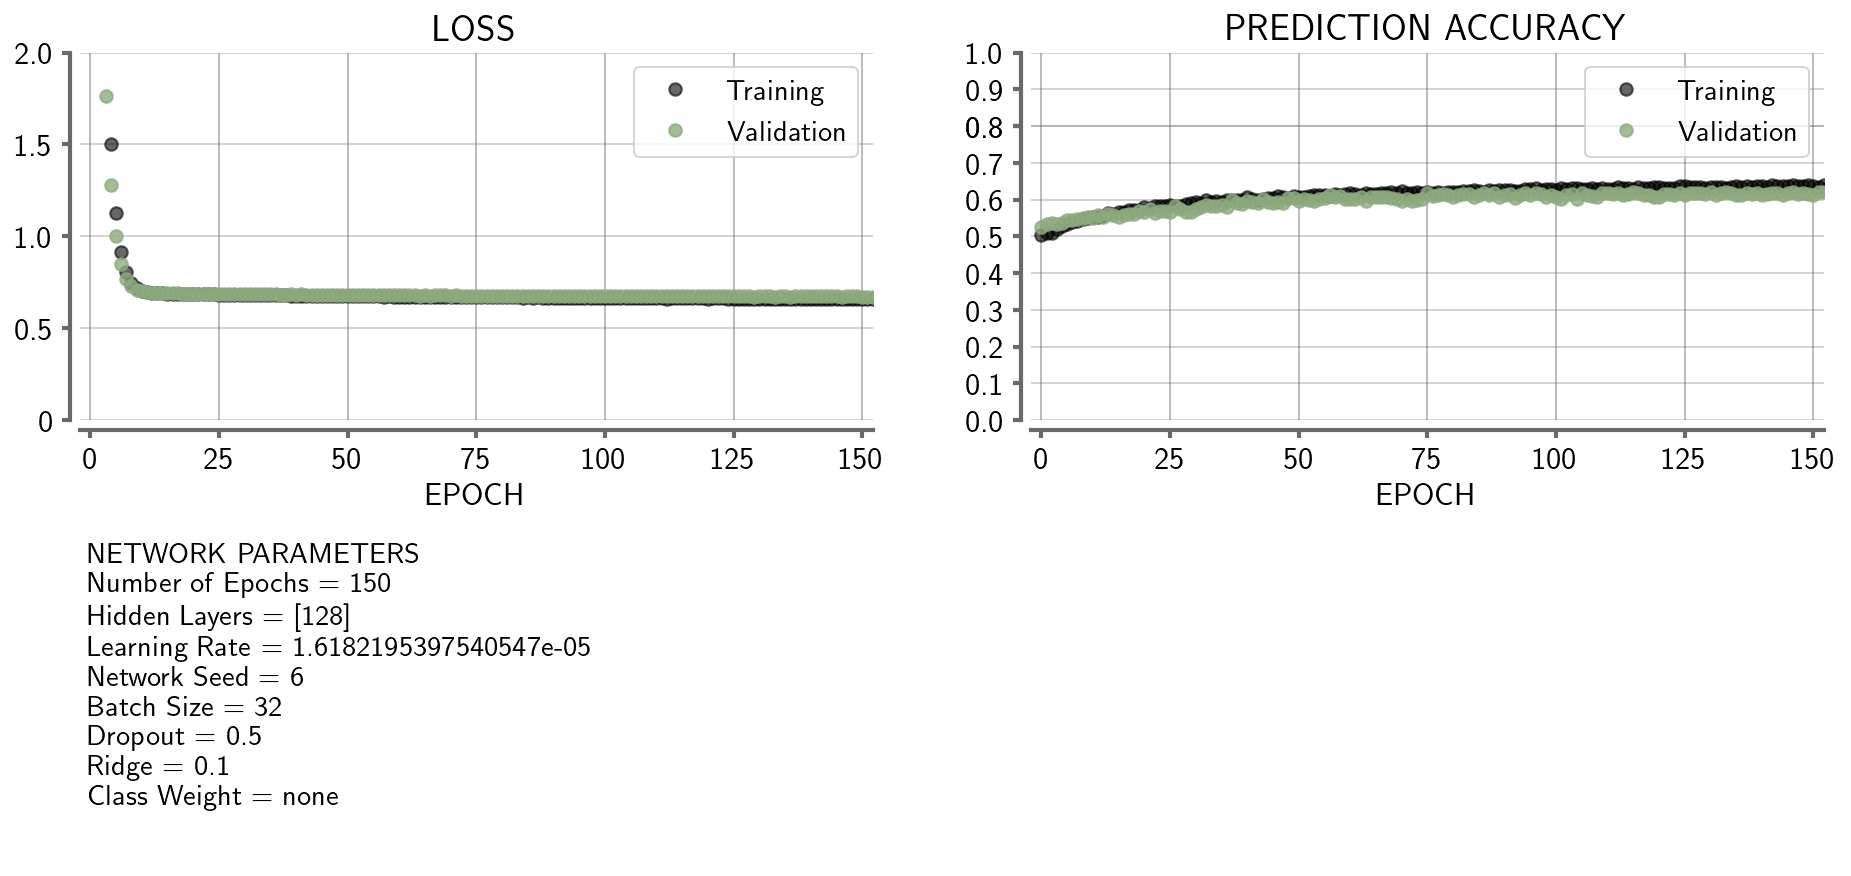

1077/1077 [==============================] - 2s 2ms/step
Zero prediction accuracy: 64%
Zero: 42.% of predictions
One prediction accuracy: 60%
One: 57.% of predictions
Validation Loss at Best Epoch: 0.6703382730484009
26
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 265)]             0         
                                                                 
 dropout (Dropout)           (None, 265)               0         
                                                                 
 dense (Dense)               (None, 128)               34048     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,306
Trainable params: 34,306
Non-trainable params: 0
___________________________________

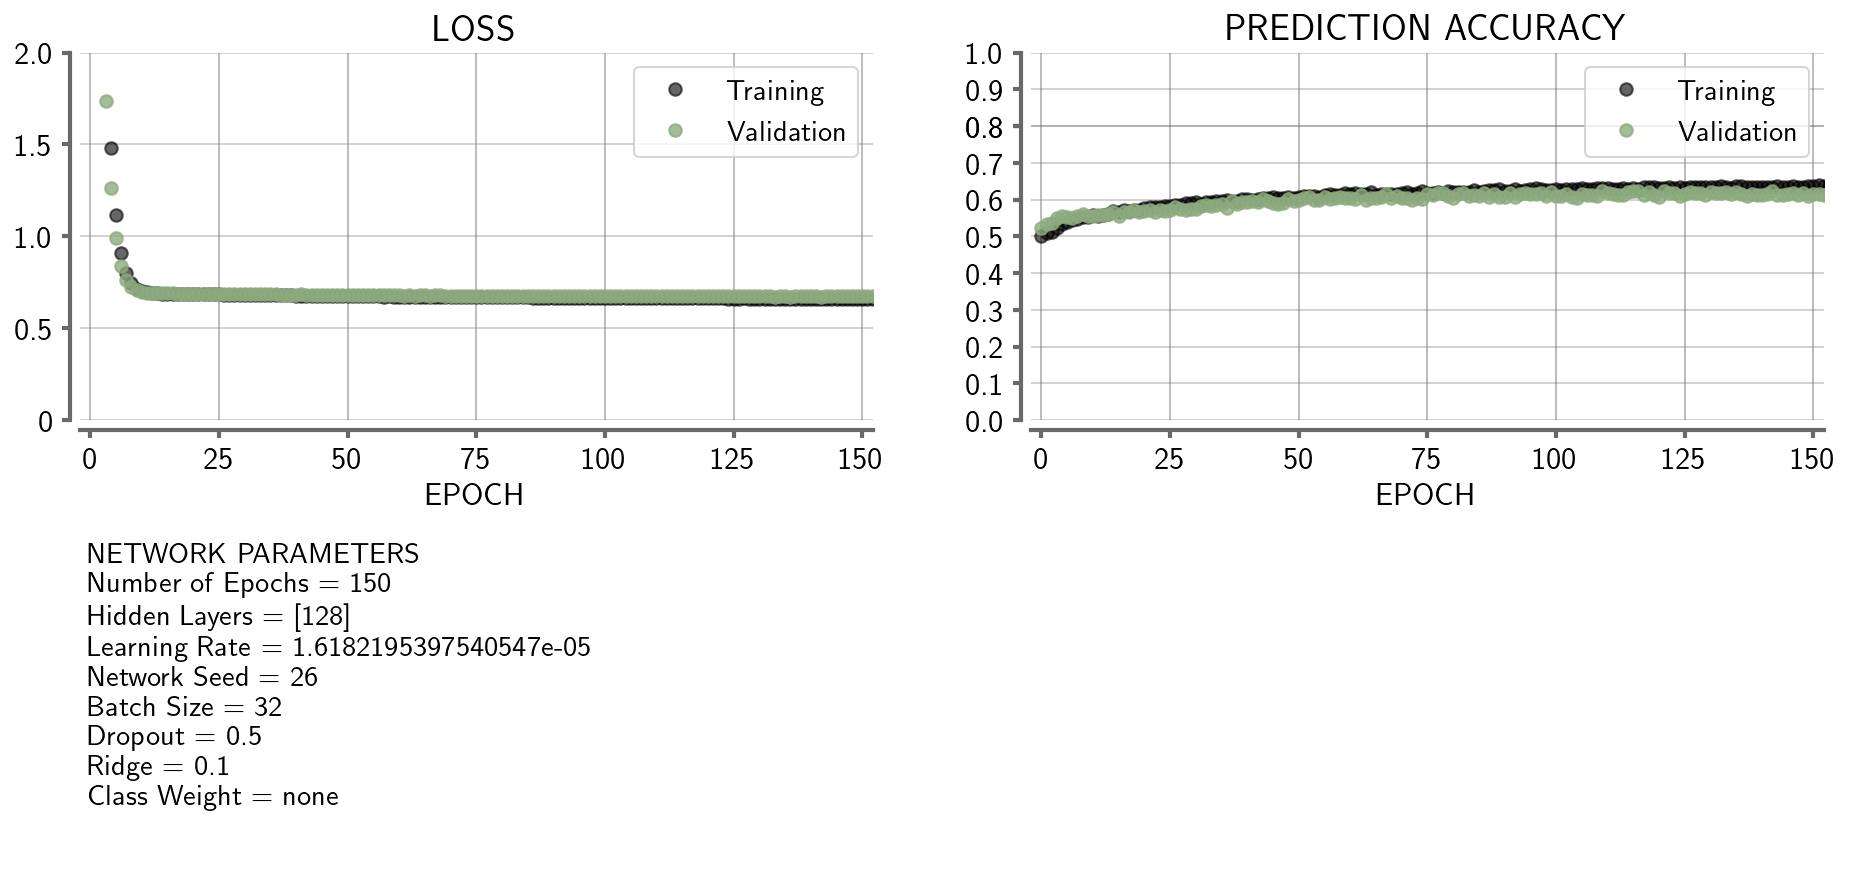

1077/1077 [==============================] - 2s 2ms/step
Zero prediction accuracy: 63%
Zero: 43.% of predictions
One prediction accuracy: 60%
One: 56.% of predictions
Validation Loss at Best Epoch: 0.6705123782157898
19
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 265)]             0         
                                                                 
 dropout (Dropout)           (None, 265)               0         
                                                                 
 dense (Dense)               (None, 128)               34048     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,306
Trainable params: 34,306
Non-trainable params: 0
___________________________________

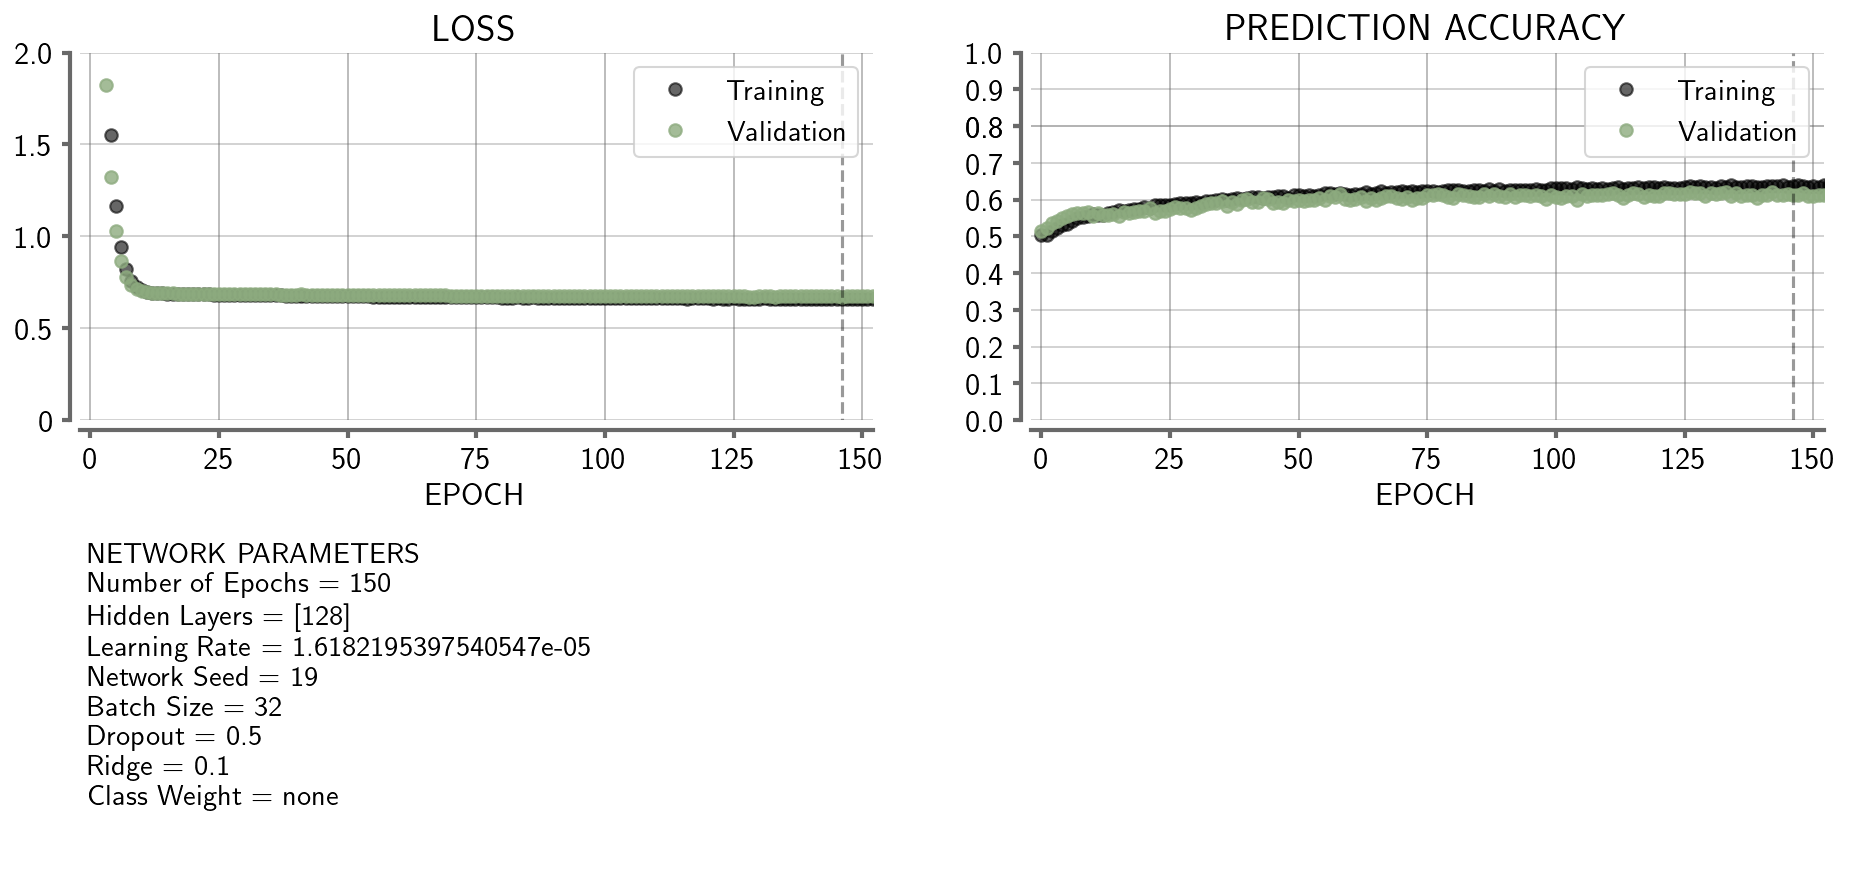

1077/1077 [==============================] - 2s 2ms/step
Zero prediction accuracy: 62%
Zero: 44.% of predictions
One prediction accuracy: 60%
One: 55.% of predictions
Validation Loss at Best Epoch: 0.6716566681861877
54
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 265)]             0         
                                                                 
 dropout (Dropout)           (None, 265)               0         
                                                                 
 dense (Dense)               (None, 128)               34048     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,306
Trainable params: 34,306
Non-trainable params: 0
___________________________________

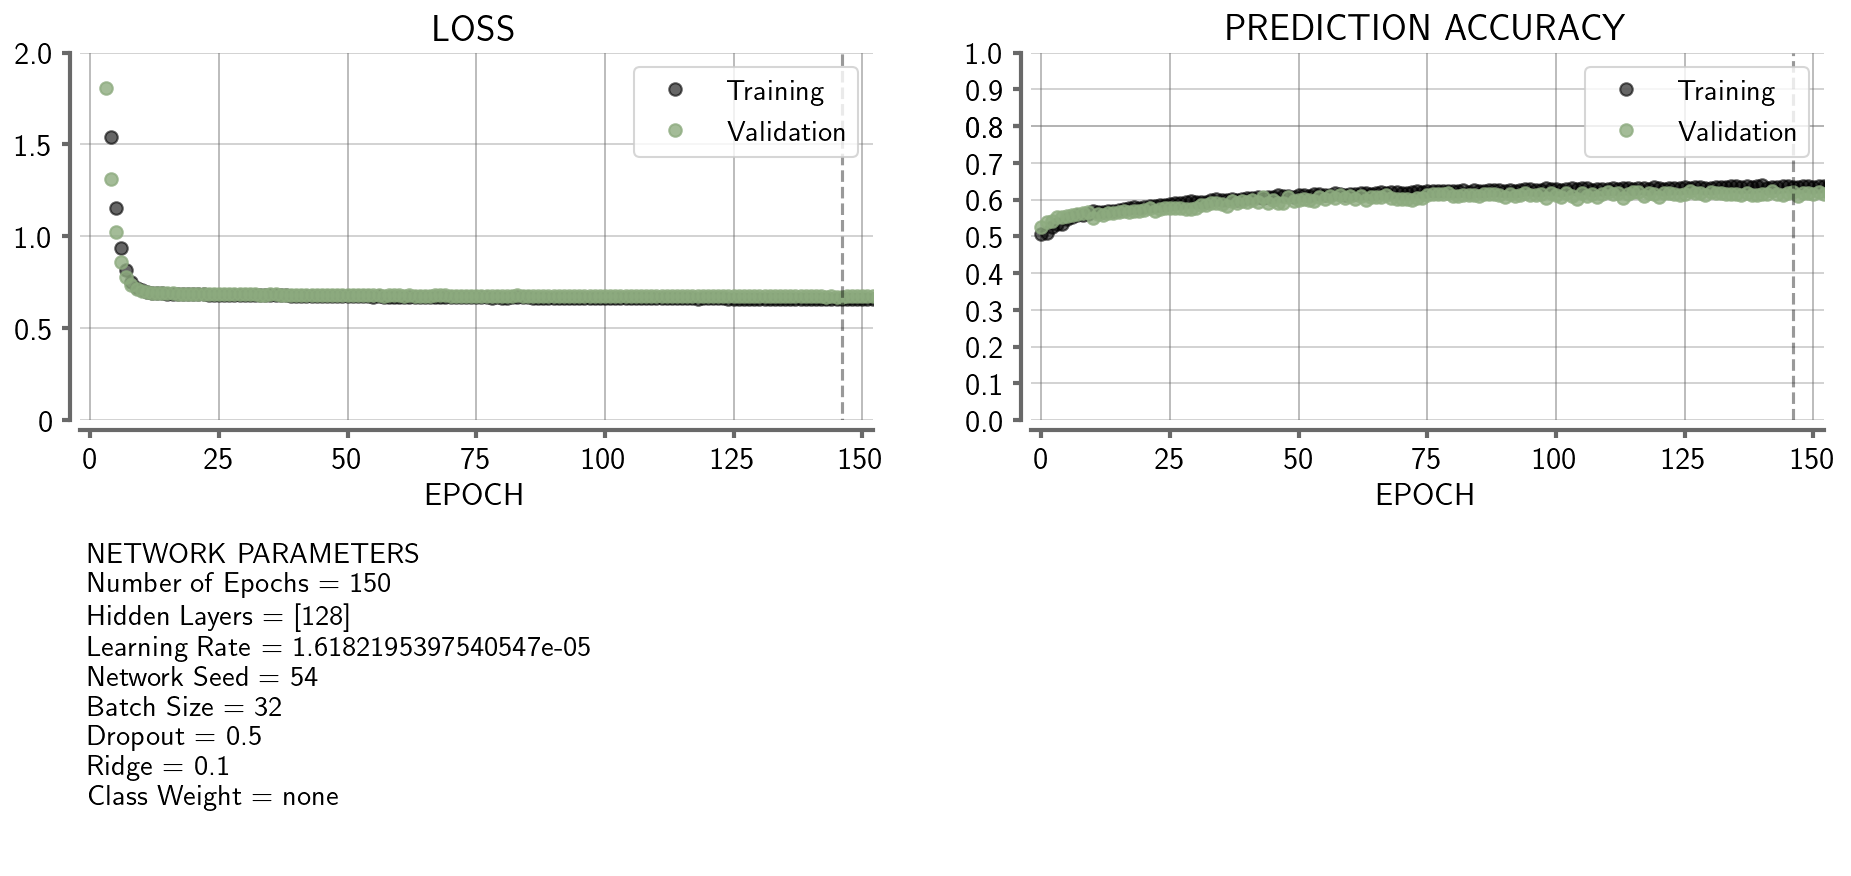

1077/1077 [==============================] - 1s 1ms/step
Zero prediction accuracy: 63%
Zero: 43.% of predictions
One prediction accuracy: 60%
One: 56.% of predictions
Validation Loss at Best Epoch: 0.670932948589325
68
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 265)]             0         
                                                                 
 dropout (Dropout)           (None, 265)               0         
                                                                 
 dense (Dense)               (None, 128)               34048     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,306
Trainable params: 34,306
Non-trainable params: 0
____________________________________

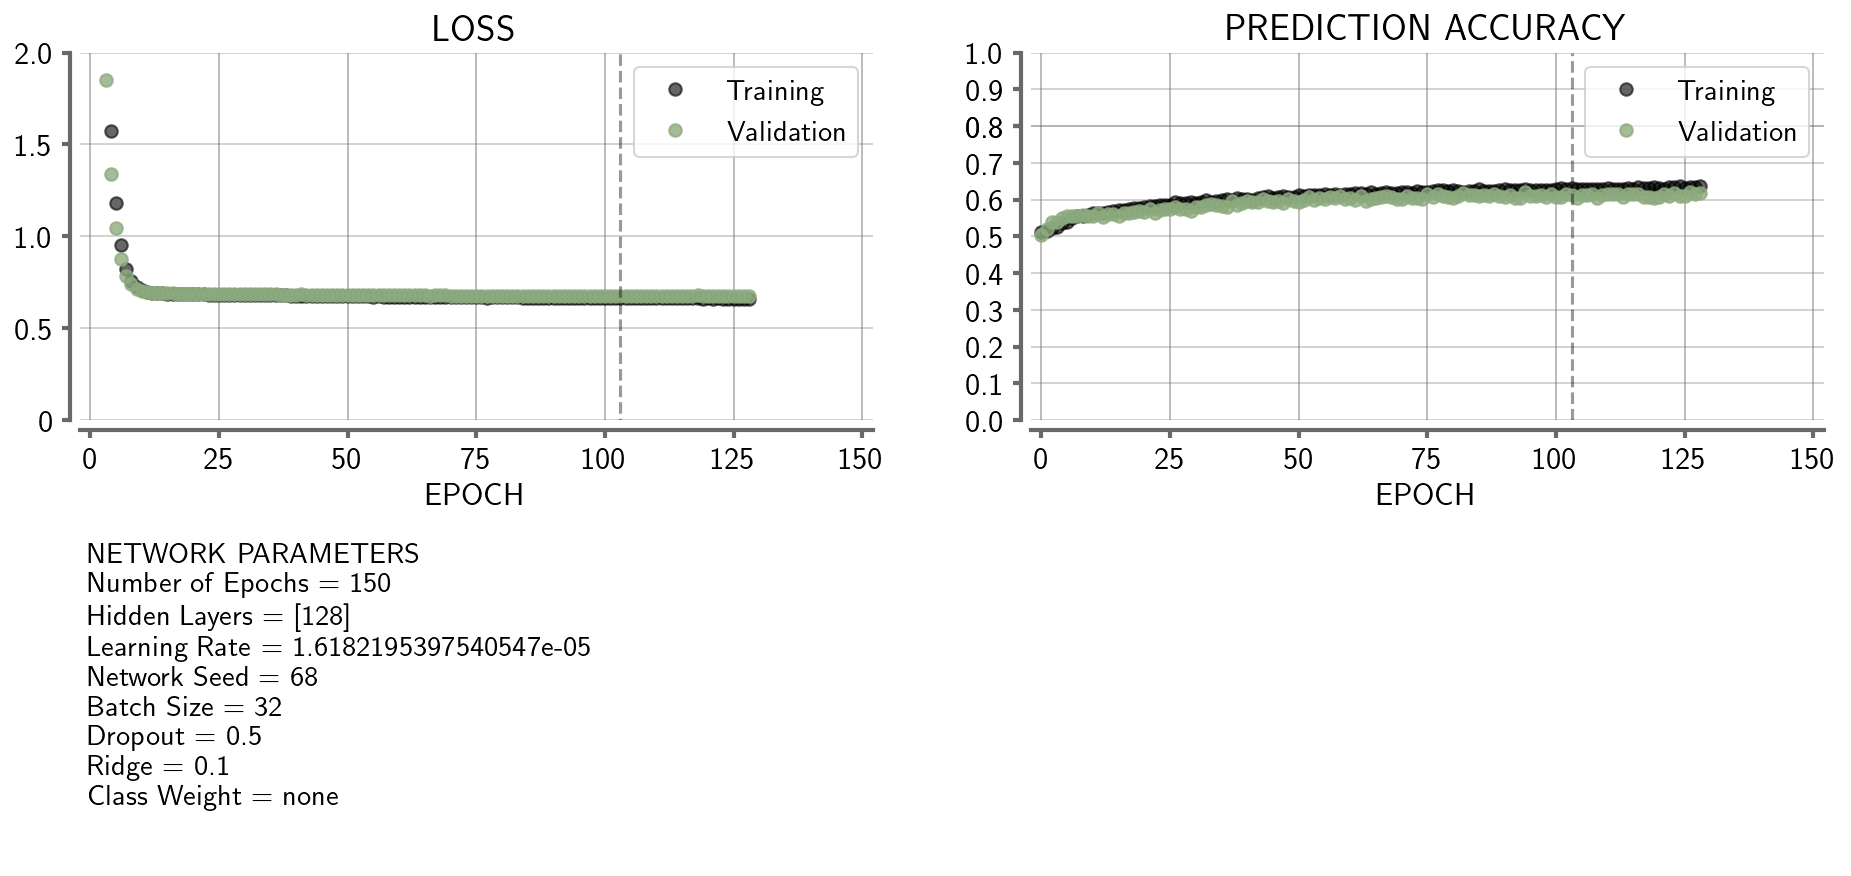

1077/1077 [==============================] - 1s 1ms/step
Zero prediction accuracy: 62%
Zero: 44.% of predictions
One prediction accuracy: 60%
One: 55.% of predictions
Validation Loss at Best Epoch: 0.6737719774246216


In [31]:
# -------------------- TRAIN NN --------------------

for NETWORK_SEED in RANDOM_SEED:
    
    print(NETWORK_SEED)
    # the network seed changes the random seed for the initialized weights.
    # this means that a different network seed can give a different result (e.g. it finds a different minimum in the loss)
    # ----- MAKE NN -----
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',     #monitor='val_prediction_accuracy'
                                                   patience=PATIENCE,
                                                   mode='auto',
                                                   restore_best_weights=True,
                                                   verbose=1)
    #lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=0) #I don't use in this study 
    #callbacks = [es_callback,lr_callback]
    callbacks = [es_callback]

    model, loss_function = make_model()
    untrained_model, loss_function = make_model()
    
     # ----- TRAINING NETWORK -----
    start_time = time.time()
    history = model.fit(X_train,
                        Y_train,
                        validation_data=(X_val, Y_val),
                        #class_weight = CLASS_WEIGHT,
                        batch_size=BATCH_SIZE,
                        epochs=N_EPOCHS,
                        shuffle=True,
                        verbose=0,
                        callbacks=callbacks,
                       )
    
    history_UNTRAINED = untrained_model.predict(X_val)
    stop_time = time.time()
    tf.print(f"Elapsed time during fit = {stop_time - start_time:.2f} seconds\n")

    # ----- SAVE MODEL -----
    fi = PREDICTOR_VAR+'_'+str(lead_weeks)+'wklead_operationalseed_testens'+str(testing_ens)+'_seed'+str(NETWORK_SEED)+'.h5'
    
    model.save_weights(ddir_out+fi)
    untrained_model.save_weights(ddir_out+'UNTRAINED_'+PREDICTOR_VAR+'_'+str(lead_weeks)+'wklead_operationalseed_testens'+str(testing_ens)+'_seed'+str(NETWORK_SEED)+'.h5')
    
    N_EPOCHS = 150
    # ----- PLOT THE RESULTS -----
    plot.plot_results(
        history,
        exp_info=(N_EPOCHS, HIDDENS, LR_INIT, BATCH_SIZE, NETWORK_SEED, PATIENCE, RIDGE1, DROPOUT, CLASS_WEIGHT),
        showplot=True
    )
    N_EPOCHS = 10000
    
    # ----- PRINT THE RESULTS -----
    predictions = np.argmax(model.predict(X_val),axis=-1)
    predictions_training = np.argmax(model.predict(X_train),axis=-1)
    confusion_training = tf.math.confusion_matrix(labels=Y_train_1D, predictions=predictions_training)
    confusion = tf.math.confusion_matrix(labels=Y_val_1D, predictions=predictions)
    zero_precision  = (np.sum(confusion[0,0])/np.sum(confusion[:,0])) * 100
    one_precision   = (np.sum(confusion[1,1])/np.sum(confusion[:,1])) * 100

    # Number of times network predicts a given class
    zero_predictions  = (np.shape(np.where(predictions==0))[1]/predictions.shape[0])* 100
    one_predictions   = (np.shape(np.where(predictions==1))[1]/predictions.shape[0])* 100

    print('Zero prediction accuracy: '+str(zero_precision)[:2]+'%')
    print('Zero: '+str(zero_predictions)[:3]+'% of predictions')
    print('One prediction accuracy: '+str(one_precision)[:2]+'%')
    print('One: '+str(one_predictions)[:3]+'% of predictions')

    print('Validation Loss at Best Epoch: '+str(es_callback.best*1))#+'%')

    # ----- END LOOP -----

# Evaluate Test Member and Metrics

In [76]:
def confusion_matrix(predclasses, targclasses):

    class_names = np.unique(targclasses)

    table = []
    for pred_class in class_names:
        row = []
        for true_class in class_names:
            row.append(100 * np.mean(predclasses[targclasses == true_class] == pred_class))
        table.append(row)
    class_titles_t = ["T(Light)", "T(Heavy)"]
    class_titles_p = ["P(Light)", "P(Heavy)"]
    conf_matrix = pd.DataFrame(table, index=class_titles_p, columns=class_titles_t)
    display(conf_matrix.style.background_gradient(cmap='Blues').format("{:.1f}"))

In [77]:
#>>>>>>>>Analyze test data on trained model<<<<<<<<
NETWORK_SEED=0
model, LOSS = make_model() 

tf.get_logger().setLevel('ERROR')


#Need to redefine empty matrices for each experiment
ind = 0

#<<<<< LOAD MODEL TO RUN CALCULATIONS ON PREDICTIONS >>>>>>>
for SEED in RANDOM_SEED:
    #if ind < num_experiments:
    model.load_weights(ddir_MODEL+PREDICTOR_VAR+'_'+str(lead_weeks)+'wklead_operationalseed_testens'+str(testing_ens)+'_seed'+str(SEED)+'.h5')

    # What predictions did the model make for our training, validation, and test sets?
    Ptrain = model.predict(X_train) # Array of class likelihoods for each class
    Pval   = model.predict(X_val)
    Ptest  = model.predict(X_test)
    
    Cptrain = Ptrain.argmax(axis=1) # 1-D array of predicted class (highest likelihood)
    Cpval   = Pval.argmax(axis=1)     #argmax along axis=1 returns the index which has the highest value for each row 
    Cptest  = Ptest.argmax(axis=1)

    Cttrain = Y_train.argmax(axis=1) # 1-D array of truth class
    Ctval   = Y_val.argmax(axis=1)
    Cttest  = Y_test.argmax(axis=1)
    
    if ind == 0:
        Cptrain_FULL = Cptrain # 1-D array of predicted class (highest likelihood)
        Cpval_FULL = Cpval     #argmax along axis=1 returns the index which has the highest value for each row 
        Cptest_FULL = Cptest
        
        Cttrain_FULL = Cttrain # 1-D array of truth class
        Ctval_FULL = Ctval
        Cttest_FULL = Cttest
        
    else:
        Cptrain_FULL = np.append(Cptrain_FULL, Cptrain)
        Cpval_FULL = np.append(Cpval_FULL, Cpval)
        Cptest_FULL = np.append(Cptest_FULL, Cptest)
                
        Cttrain_FULL = np.append(Cttrain_FULL, Cttrain)
        Ctval_FULL = np.append(Ctval_FULL, Ctval)
        Cttest_FULL = np.append(Cttest_FULL, Cttest)
    
    ind += 1

# Confusion Matrix percentages

print("Predicted versus Target Classes")
#print("")
print("Training")
confusion_matrix(Cptrain_FULL, Cttrain_FULL)
print("Validation")
confusion_matrix(Cpval_FULL, Ctval_FULL)
print("Testing")
confusion_matrix(Cptest_FULL, Cttest_FULL)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 265)]             0         
                                                                 
 dropout (Dropout)           (None, 265)               0         
                                                                 
 dense (Dense)               (None, 128)               34048     
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 34,306
Trainable params: 34,306
Non-trainable params: 0
_________________________________________________________________
154/154 [==============================] - 0s 1ms/step
Predicted versus Target Classes
Training


,T(Light),T(Heavy)
P(Light),55.5,21.7
P(Heavy),44.5,78.3


Validation


,T(Light),T(Heavy)
P(Light),55.5,31.4
P(Heavy),44.5,68.6


Testing


,T(Light),T(Heavy)
P(Light),55.0,33.2
P(Heavy),45.0,66.8


1538/1538 [==============================] - 1s 649us/step


Text(40.722222222222214, 0.5, 'True')

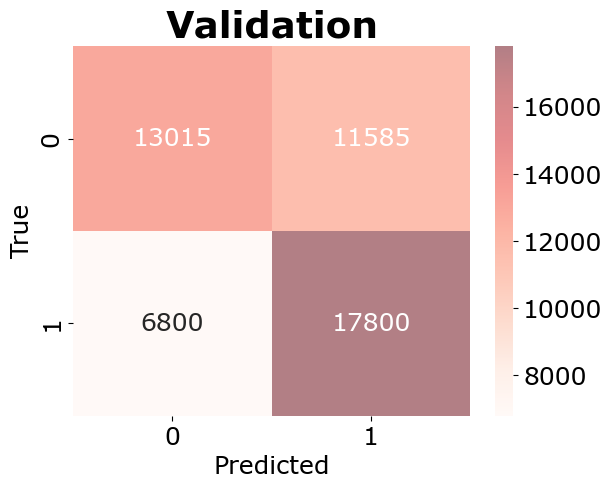

In [78]:
# Confusion Matrix Values
#Need to redefine empty matrices for each experiment
ind = 0

#<<<<< LOAD MODEL TO RUN CALCULATIONS ON PREDICTIONS >>>>>>>
for SEED in RANDOM_SEED:
    #if ind < num_experiments:
    model.load_weights(ddir_MODEL+PREDICTOR_VAR+'_'+str(lead_weeks)+'wklead_operationalseed_testens'+str(testing_ens)+'_seed'+str(SEED)+'.h5')
    
    if ind == 0:
        X_val_FULL = X_val
        Y_val_1D_FULL = Y_val_1D  
        X_test_FULL = X_test
        Y_test_1D_FULL = Y_test_1D    
    else:
        X_val_FULL = np.append(X_val_FULL, X_val, axis=0)
        Y_val_1D_FULL = np.append(Y_val_1D_FULL, Y_val_1D)
        X_test_FULL = np.append(X_test_FULL, X_test, axis=0)
        Y_test_1D_FULL = np.append(Y_test_1D_FULL, Y_test_1D)
    
    ind += 1


# What predictions did the model make for our training, validation, and test sets?
predictions = np.argmax(model.predict(X_val_FULL),axis=-1)
confusion = tf.math.confusion_matrix(labels=Y_val_1D_FULL, predictions=predictions)

# confusion = f'{confusion:.20f}'
sns.heatmap(confusion,annot=True,cmap=plt.cm.Reds, alpha=0.5, fmt ='g')
plt.title('Validation')
plt.xlabel('Predicted')
plt.ylabel('True')

769/769 [==============================] - 0s 591us/step


Text(40.722222222222214, 0.5, 'True')

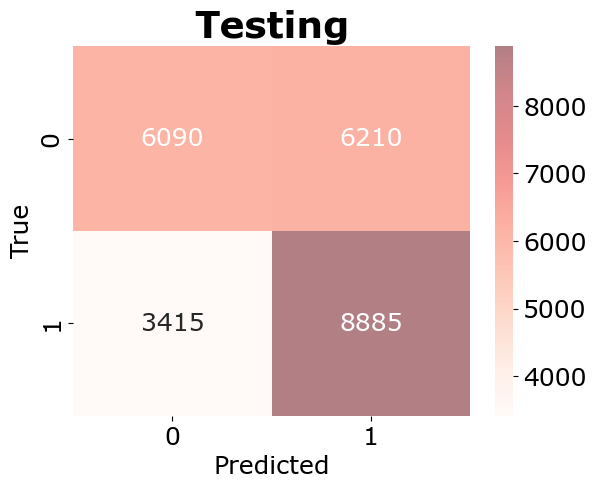

In [79]:
# What predictions did the model make for our training, validation, and test sets?
predictions = np.argmax(model.predict(X_test_FULL),axis=-1)
confusion = tf.math.confusion_matrix(labels=Y_test_1D_FULL, predictions=predictions)

# confusion = f'{confusion:.20f}'
sns.heatmap(confusion,annot=True,cmap=plt.cm.Reds, alpha=0.5, fmt ='g')
plt.title('Testing')
plt.xlabel('Predicted')
plt.ylabel('True')

In [80]:
ddir_saveinfo

'/Users/marcodia/Research/salinity_s2s/experiments/no_arctic/evaluations/'

In [82]:
#.............................................
# XAI functions
#.............................................

# before calling these functions in your notebook, make sure you have defined the tensorflow object "model". 
# The "model" is the machine learning model (e.g., neural network) that you want to explain. 

# Code author of XAI functions: Libby Barnes and Tony Mamalakis

def get_gradients(inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads

def get_integrated_gradients(inputs, baseline=None, num_steps=50, top_pred_idx=None):
    """Computes Integrated Gradients for a prediction.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        baseline (ndarray): The baseline image to start with for interpolation
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.            

    Returns:
        Integrated gradients w.r.t input image
    """
    # If baseline is not provided, start with zeros
    # having same size as the input image.
    if baseline is None:
        input_size = np.shape(inputs)[1:]
        baseline = np.zeros(input_size).astype(np.float32)
    else:
        baseline = baseline.astype(np.float32)

    # 1. Do interpolation.
    inputs = inputs.astype(np.float32)
    interpolated_inputs = [
        baseline + (step / num_steps) * (inputs - baseline)
        for step in range(num_steps + 1)
    ]
    interpolated_inputs = np.array(interpolated_inputs).astype(np.float32)

    # 3. Get the gradients
    grads = []
    for i, x_data in enumerate(interpolated_inputs):
        grad = get_gradients(x_data, top_pred_idx=top_pred_idx)
        grads.append(grad)
    grads = tf.convert_to_tensor(grads, dtype=tf.float32)

    # 4. Approximate the integral using the trapezoidal rule
    grads = (grads[:-1] + grads[1:]) / 2.0
    avg_grads = tf.reduce_mean(grads, axis=0)

    # 5. Calculate integrated gradients and return
    integrated_grads = (inputs - baseline) * avg_grads
    return integrated_grads

def random_baseline_integrated_gradients(inputs, num_steps=50, num_runs=5, top_pred_idx=None):
    """Generates a number of random baseline images.

    Args:
        inputs (ndarray): 2D/3D/4D matrix of samples
        num_steps: Number of interpolation steps between the baseline
            and the input used in the computation of integrated gradients. These
            steps along determine the integral approximation error. By default,
            num_steps is set to 50.
        num_runs: number of baseline images to generate
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.      

    Returns:
        Averaged integrated gradients for `num_runs` baseline images
    """
    # 1. List to keep track of Integrated Gradients (IG) for all the images
    integrated_grads = []

    # 2. Get the integrated gradients for all the baselines
    for run in range(num_runs):
        baseline = np.zeros(np.shape(inputs)[1:])
        for i in np.arange(0,np.shape(baseline)[0]):
            j = np.random.choice(np.arange(0,np.shape(inputs)[0]))
            baseline[i] = inputs[j,i]

        igrads = get_integrated_gradients(
            inputs=inputs,
            baseline=baseline,
            num_steps=num_steps,
        )
        integrated_grads.append(igrads)

    # 3. Return the average integrated gradients for the image
    integrated_grads = tf.convert_to_tensor(integrated_grads)
    return tf.reduce_mean(integrated_grads, axis=0)



## compute accuracy vs confidence

In [83]:
num_seeds = len(RANDOM_SEED)

prect_lat = np.array(Xval1.lat)
prect_lon = np.array(Xval1.lon)

#>>>>>>>>Analyze test data on trained model<<<<<<<<
NETWORK_SEED=99

tf.get_logger().setLevel('ERROR')


#<<<<< LOAD MODEL TO RUN CALCULATIONS ON PREDICTIONS >>>>>>>

X1= X_test.copy(deep=True)

#Need to redefine empty matrices for each experiment
ind = 0
acc_train = np.zeros(shape=(num_seeds,20)) + np.nan
acc_val = np.zeros(shape=(num_seeds,20)) + np.nan
acc_test = np.zeros(shape=(num_seeds,20)) + np.nan
stored_accuracy = np.zeros(len(RANDOM_SEED))


#<<<<< LOAD MODEL TO RUN CALCULATIONS ON PREDICTIONS >>>>>>>
for SEED in RANDOM_SEED:
    #if ind < num_experiments:
    model.load_weights(ddir_MODEL+PREDICTOR_VAR+'_'+str(lead_weeks)+'wklead_operationalseed_testens'+str(testing_ens)+'_seed'+str(SEED)+'.h5')

    #<<<Apply testing data to trained model>>>>>>>>>>>>> 
    #**** To evaluate XAI on validation or testing, just change Ptest and Cttest_true)********
    
    Ptest = model.predict(X_test)    #predicted values on test data - softmax output of confidence 
    Cptest_pred = Ptest.argmax(axis=1)     #0,1 of predicted  
    Cttest_true = Y_test.argmax(axis=1) #true values on validation 

    conf_pred_test = model.predict(X_test)           # softmax output
    cat_pred_test  = np.argmax(conf_pred_test, axis = 1) # categorical output
    max_conf_test  = np.max(conf_pred_test, axis = 1)   # predicted category confidence
                       
    conf_pred_val = model.predict(X_val)           # softmax output
    cat_pred_val  = np.argmax(conf_pred_val, axis = 1) # categorical output
    max_conf_val  = np.max(conf_pred_val, axis = 1)   # predicted category confidence

    results_test = model.evaluate(X_test,Y_test,verbose = 2) #prints out model evaluation 
    stored_accuracy[ind] = results_test[2]
    
    # ----- EVALUATE MODEL -----  
    conf_pred_train = model.predict(X_train)           # softmax output
    cat_pred_train  = np.argmax(conf_pred_train, axis = 1) # categorical output
    max_conf_train  = np.max(conf_pred_train, axis = 1)   # predicted category confidence

    #<<<< Rank data into most confident predictions for testing and validation>>>>>>>
            
    for p,per in enumerate(np.arange(0,100,5)):
        if ind < num_seeds: 
            i_cover_train = np.where(max_conf_train >= np.percentile(max_conf_train,per))[0]
            icorr_train   = np.where(cat_pred_train[i_cover_train] == Y_train_1D[i_cover_train])[0]
            if len(i_cover_train) == 0:
                acc_train[ind,p] = 0.
            else:
                acc_train[ind,p] = (len(icorr_train)/len(i_cover_train)) * 100   

    for p,per in enumerate(np.arange(0,100,5)):
        if ind < num_seeds: 
            i_cover_val = np.where(max_conf_val >= np.percentile(max_conf_val,per))[0]
            icorr_val   = np.where(cat_pred_val[i_cover_val] == Y_val_1D[i_cover_val])[0]
            if len(i_cover_val) == 0:
                acc_val[ind,p] = 0.
            else:
                acc_val[ind,p] = (len(icorr_val)/len(i_cover_val)) * 100
    
    for p,per in enumerate(np.arange(0,100,5)):
        if ind < num_seeds: 
            i_cover_test = np.where(max_conf_test >= np.percentile(max_conf_test,per))[0]
            icorr_test   = np.where(cat_pred_test[i_cover_test] == Y_test_1D[i_cover_test])[0]
            if len(i_cover_test) == 0:
                acc_test[ind,p] = 0.
            else:
                acc_test[ind,p] = (len(icorr_test)/len(i_cover_test)) * 100

    ind += 1
    
stored_accuracy_xr = xr.DataArray(stored_accuracy)
filename_acc = 'overall_accuracy_'+str(lead_weeks)+'wklead_testens'+str(testing_ens)+'.nc'
stored_accuracy_xr.to_netcdf(ddir_saveinfo+filename_acc, mode='w')

acc_vs_conf_val = xr.DataArray(acc_test)
filename_val = 'confidence_vs_accuracy_VALIDATION_'+str(lead_weeks)+'wklead_testens'+str(testing_ens)+'.nc'
acc_vs_conf_val.to_netcdf(ddir_saveinfo+filename_val, mode='w')      

acc_vs_conf_test = xr.DataArray(acc_test)
filename_test = 'confidence_vs_accuracy_TESTING_'+str(lead_weeks)+'wklead_testens'+str(testing_ens)+'.nc'
acc_vs_conf_test.to_netcdf(ddir_saveinfo+filename_test, mode='w')

308/308 [==============================] - 1s 2ms/step
154/154 - 1s - loss: 0.6774 - categorical_accuracy: 0.6075 - prediction_accuracy: 0.6075 - 580ms/epoch - 4ms/step
308/308 [==============================] - 1s 3ms/step
154/154 - 0s - loss: 0.6788 - categorical_accuracy: 0.6096 - prediction_accuracy: 0.6096 - 399ms/epoch - 3ms/step
308/308 [==============================] - 1s 2ms/step
154/154 - 0s - loss: 0.6763 - categorical_accuracy: 0.6118 - prediction_accuracy: 0.6118 - 337ms/epoch - 2ms/step
308/308 [==============================] - 1s 2ms/step
154/154 - 0s - loss: 0.6782 - categorical_accuracy: 0.6079 - prediction_accuracy: 0.6079 - 441ms/epoch - 3ms/step
308/308 [==============================] - 1s 2ms/step
154/154 - 0s - loss: 0.6756 - categorical_accuracy: 0.6087 - prediction_accuracy: 0.6087 - 392ms/epoch - 3ms/step
1077/1077 [==============================] - 3s 2ms/step


## XAI calculations

In [84]:
correct_predictions0_array = []
correct_predictions1_array = []

perc = 80 #(100-perc)% of predictions
conf_level = 'most'
subset = 'correct'
X1= X_test.copy(deep=True)

seed_winner_trained = np.argmax(np.array(stored_accuracy[:]))

for SEED in [RANDOM_SEED[seed_winner_trained]]:
    #**** To evaluate XAI on validation or testing, just change Ptest and Cttest_true)********
    
    Ptest = model.predict(X_test)    #predicted values on test data - softmax output of confidence 
    Cptest_pred = Ptest.argmax(axis=1)     #0,1 of predicted  
    Cttest_true = Y_test.argmax(axis=1) #true values on validation 


    #<<<<<<<<<<<Split most confident data into correct and incorrect>>>>>>>
    #softmax:

    max_logits = np.max(Ptest,axis=-1)
    if conf_level == 'most':
        i_cover = np.where(max_logits >= np.percentile(max_logits, perc))[0]

    if conf_level == 'least':
        i_cover = np.where(max_logits < np.percentile(max_logits, perc))[0]
    
    #i_cover = np.where(max_logits >= np.percentile(max_logits, perc))[0]

    cat_true_conf = Cttest_true[i_cover]
    cat_pred_conf = Cptest_pred[i_cover]

    if subset == 'correct':
        #location of correct predictions
        icorr = np.where(Cptest_pred[i_cover] - Cttest_true[i_cover] == 0)[0]
        X1_subset = X1[i_cover][icorr] #index Xtest with indicies of CONFIDENT & CORRECT predictions; for output compositing, replace X1 with Y variable 
        X_subset_time = X1.time[i_cover][icorr] #index with indicies of CONFIDENT & CORRECT predictions
        Y_true_subset = cat_true_conf[icorr]
        Y_pred_subset = cat_pred_conf[icorr]
        time = X_test.time[icorr]

    if subset == 'incorrect': #confident but incorrect/wrong prediction
        #location of incorrect predictions
        i_incorr = np.where(Cptest_pred[i_cover] - Cttest_true[i_cover] != 0)[0]
        X1_subset = X1[i_cover][i_incorr] #index Xtest with indicies of INCORRECT predictions
        X_subset_time = X1.time[i_cover][i_incorr] #index with indicies of INCORRECT predictions
        Y_true_subset = cat_true_conf[i_incorr]
        Y_pred_subset = cat_pred_conf[i_incorr]
        time = X_test.time[i_incorr]

    if subset == 'all':    #all confident predictions (correct and incorrect) 
        i_incorr = np.where(Cptest_pred[i_cover] - Cttest_true[i_cover] <= 1)[0]
        X1_subset = X1[i_cover][i_incorr] #index Xtest with indicies of ALL predictions
        X_subset_time = X1.time[i_cover][i_incorr] #index with indicies of ALL predictions
        Y_true_subset = cat_true_conf[i_incorr]
        Y_pred_subset = cat_pred_conf[i_incorr]
        time = X_test.time[i_incorr]

    sample = X1_subset.copy()
    icat = np.where(Y_true_subset == 0)[0] # will be the same category as predicted if subset = 'correct'
    time_class = time[icat]
    Data0 = X1_subset[icat]

    correct_predictions0=Data0 
#    if ind == 0:
    correct_predictions0_array = Data0
    #else:
    #    correct_predictions0_array = xr.concat([correct_predictions0_array, Data0], dim='time')
    
    sample = X1_subset.copy()
    icat = np.where(Y_true_subset == 1)[0]# will be the same category as predicted if subset = 'correct'
    time_class = time[icat]
    Data1 = X1_subset[icat]

    correct_predictions1=Data1
    #if ind == 0:
    correct_predictions1_array = Data1
#    else:
#        correct_predictions1_array = xr.concat([correct_predictions1_array, Data1], dim='time')

    XAI_pred0_true0_stack = get_integrated_gradients(correct_predictions0,baseline=None, num_steps=50, top_pred_idx=0)
    XAI_pred0_true0_full = XAI_pred0_true0_stack.unstack(dim='z')
    # if ind == 0:
    #     XAI_pred0_true0_full = XAI_pred0_true0_exp
    # else:
    #     XAI_pred0_true0_full = np.concatenate((XAI_pred0_true0_full,XAI_pred0_true0_exp), axis=0)
    # print(XAI_pred0_true0_full.shape)

    XAI_pred1_true1_stack = get_integrated_gradients(correct_predictions1,baseline=None, num_steps=50, top_pred_idx=1)
    XAI_pred1_true1_full = XAI_pred1_true1_stack.unstack(dim='z')
#     if ind == 0:
#         XAI_pred1_true1_full = XAI_pred1_true1_exp
#     else:
#         XAI_pred1_true1_full = np.append(XAI_pred1_true1_full,XAI_pred1_true1_exp, axis=0)
     
#     print(XAI_pred1_true1_full.shape)

    ind += 1
    
XAI_pred0_true0_full_xr = xr.DataArray(XAI_pred0_true0_full)
filename_acc = 'XAI_pred0_true0_'+str(lead_weeks)+'wklead_testens'+str(testing_ens)+'.nc'
XAI_pred0_true0_full_xr.to_netcdf(ddir_saveinfo+filename_acc, mode='w')

XAI_pred1_true1_full_xr = xr.DataArray(XAI_pred1_true1_full)
filename_acc = 'XAI_pred1_true1_'+str(lead_weeks)+'wklead_testens'+str(testing_ens)+'.nc'
XAI_pred1_true1_full_xr.to_netcdf(ddir_saveinfo+filename_acc, mode='w')

154/154 [==============================] - 0s 2ms/step


In [89]:
XAI_pred0_true0_full

<xarray.DataArray (time: 315, lat: 17, lon: 23)>
array([[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.34613132e-03, -1.21106699e-04, -6.40387079e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          8.41327346e-05,  2.76322011e-03,  6.85616210e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          5.81195951e-03, -8.55602440e-04,  4.23325505e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          3.17066201e-06,  6.84409606e-05,  7.80248229e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.74178145e-04, -3.62958875e-04, -6.77797536e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.84687041e-03, -8.66602175e-04, -1.56268768e-03]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.43845240e-03, -7.92405990e-05, -4.29966894e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          8.75206824e-05,  2.67360057e-03,  6.78857090e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          5.76091139e-03, -1.13491865e-03,  3.84572684e-03],
...
          1.79764858e-04,  1.58413226e-04,  6.73837203e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -2.58619577e-04,  1.36937801e-04, -1.20906952e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.42240606e-03, -6.25017681e-04,  2.80099971e-06]],

       [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -6.88848493e-04,  2.20535677e-02,  5.63500300e-02],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.43675526e-04,  2.13402716e-04, -2.29511829e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          2.19116337e-03, -1.15489215e-03, -6.84856728e-04],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.64473749e-04,  2.20502785e-04,  6.95231021e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.72265107e-04,  1.33982787e-04, -1.37152398e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.33760576e-03, -5.39686123e-04,  8.76980193e-05]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float64 8.75 11.25 13.75 16.25 ... 41.25 43.75 46.25 48.75
  * lon      (lon) float64 265.0 267.5 270.0 272.5 ... 312.5 315.0 317.5 320.0
  * time     (time) object 1852-07-24 00:00:00 ... 1948-08-31 00:00:00

env: PYTHONHASHSEED=99


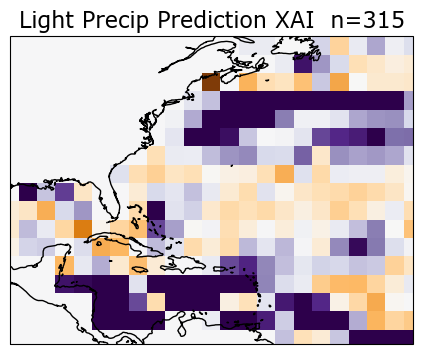

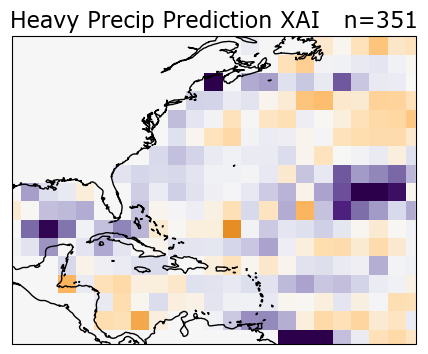

In [85]:
#Separate Clusters/Composites for Positive and Negative Predictions
#Clustering code adopted from github.com/eabarnes1010

# set random seed so we get identical results every time
%env PYTHONHASHSEED=99
np.random.seed(99)

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans,vq
import matplotlib.cm as cm
import matplotlib as mpl

linewidth_default = 2.0
fig_text_default = 18.
fig_title_default = fig_text_default*1.5

plt.rc('lines', linewidth=linewidth_default)    
plt.rc('text', usetex=False)
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 100

#XAI_pred0_true0_full[np.isnan(XAI_pred0_true0_full)] = 0
XAI_pred0_true0_full = XAI_pred0_true0_full.fillna(0)

data = np.array(XAI_pred0_true0_full)
lat = Xval.lat
lon = Xval.lon

#----------- MODIFY -------------------------
numclust = 1            # number of clusters to fit
n_iters_vec = [100,]     # number of full iterations run, then take the best one
#--------------------------------------------

dist_vec = np.asarray([])
for n_iters in n_iters_vec:
    clusters, dist = kmeans(data.reshape(data.shape[0],data.shape[1]*data.shape[2]), numclust, iter=n_iters)
    classes, _ = vq(data.reshape(data.shape[0],data.shape[1]*data.shape[2]),clusters)
    dist_vec = np.append(dist_vec,dist)  

min_level = -0.003 
max_level = 0.003 
step_level = 0.0001
levels = np.arange(min_level,max_level,step_level)
cmap = 'PuOr'
extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]

for cluster in np.arange(0,numclust):
    fig, (ax0) = plt.subplots(nrows=1,ncols=1, figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=200)})
    xplot = clusters[cluster,:].reshape(len(lat),len(lon))
    count = np.count_nonzero(classes == cluster)
    ax0.set_title('Light Precip Prediction XAI  n='+str(count), fontsize = '16', fontweight = 'light')
    xplot, cyclic_lons = add_cyclic_point(xplot, coord=prect_lon)
    cf0 = ax0.pcolor(cyclic_lons,lat,xplot, transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
    ax0.add_feature(cfeature.COASTLINE)
    ax0.set_extent([min_lon,max_lon,min_lat,max_lat],crs=ccrs.PlateCarree())
    #fig.colorbar(cf0,ax=ax0)

    plt.show()

#XAI_pred1_true1_full[np.isnan(XAI_pred1_true1_full)] = 0
XAI_pred1_true1_full = XAI_pred1_true1_full.fillna(0)

data = np.array(XAI_pred1_true1_full)


#----------- MODIFY -------------------------
numclust = 1            # number of clusters to fit
n_iters_vec = [100,]     # number of full iterations run, then take the best one
#--------------------------------------------

dist_vec = np.asarray([])
for n_iters in n_iters_vec:
    clusters, dist = kmeans(data.reshape(data.shape[0],data.shape[1]*data.shape[2]), numclust, iter=n_iters)
    classes, _ = vq(data.reshape(data.shape[0],data.shape[1]*data.shape[2]),clusters)
    dist_vec = np.append(dist_vec,dist) 

# min_level = -0.0000005 
# max_level = 0.000005 
# step_level = 0.0000005


levels = np.arange(min_level,max_level,step_level)
cmap = 'PuOr'
extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]


for cluster in np.arange(0,numclust):
    fig, (ax0) = plt.subplots(nrows=1,ncols=1, figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=200)})
    xplot = clusters[cluster,:].reshape(len(lat),len(lon))
    count = np.count_nonzero(classes == cluster)
    ax0.set_title('Heavy Precip Prediction XAI   n='+str(count), fontsize = '16', fontweight = 'light')

    xplot, cyclic_lons = add_cyclic_point(xplot, coord=prect_lon)
    cf0 = ax0.pcolor(cyclic_lons,lat,xplot, transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
    ax0.add_feature(cfeature.COASTLINE)
    ax0.set_extent([min_lon,max_lon,min_lat,max_lat],crs=ccrs.PlateCarree())
    #fig.colorbar(cf0,ax=ax0)

    plt.show()


In [86]:
acc_untrained = np.zeros(shape=(num_seeds,20)) + np.nan
ind = 0
#<<<<< LOAD MODEL TO RUN CALCULATIONS ON PREDICTIONS >>>>>>>
for NETWORK_SEED in RANDOM_SEED:
    #if ind < num_experiments:
    model.load_weights(ddir_MODEL+'UNTRAINED_'+PREDICTOR_VAR+'_'+str(lead_weeks)+'wklead_operationalseed_testens'+str(testing_ens)+'_seed'+str(NETWORK_SEED)+'.h5')

    conf_pred_test = model.predict(X_test)           # softmax output
    cat_pred_test  = np.argmax(conf_pred_test, axis = 1) # categorical output
    max_conf_test  = np.max(conf_pred_test, axis = 1)   # predicted category confidence
                       
#     conf_pred_val = model.predict(X_val)           # softmax output
#     cat_pred_val  = np.argmax(conf_pred_val, axis = 1) # categorical output
#     max_conf_val  = np.max(conf_pred_val, axis = 1)   # predicted category confidence

#     results_test = model.evaluate(X_val,Y_val,verbose = 2) #prints out model evaluation 
     
    for p,per in enumerate(np.arange(0,100,5)):
        if ind < num_seeds: 
            i_cover_test = np.where(max_conf_test >= np.percentile(max_conf_test,per))[0]
            icorr_test   = np.where(cat_pred_test[i_cover_test] == Y_test_1D[i_cover_test])[0]
            if len(i_cover_test) == 0:
                acc_untrained[ind,p] = 0.
            else:
                acc_untrained[ind,p] = (len(icorr_test)/len(i_cover_test)) * 100
    ind += 1

acc_untrained_xr = xr.DataArray(acc_untrained)
filename_UTacc = 'untrained_accuracy_'+str(lead_weeks)+'wklead_testens'+str(testing_ens)+'.nc'
acc_untrained_xr.to_netcdf(ddir_saveinfo+filename_UTacc, mode='w')


154/154 [==============================] - 0s 2ms/step


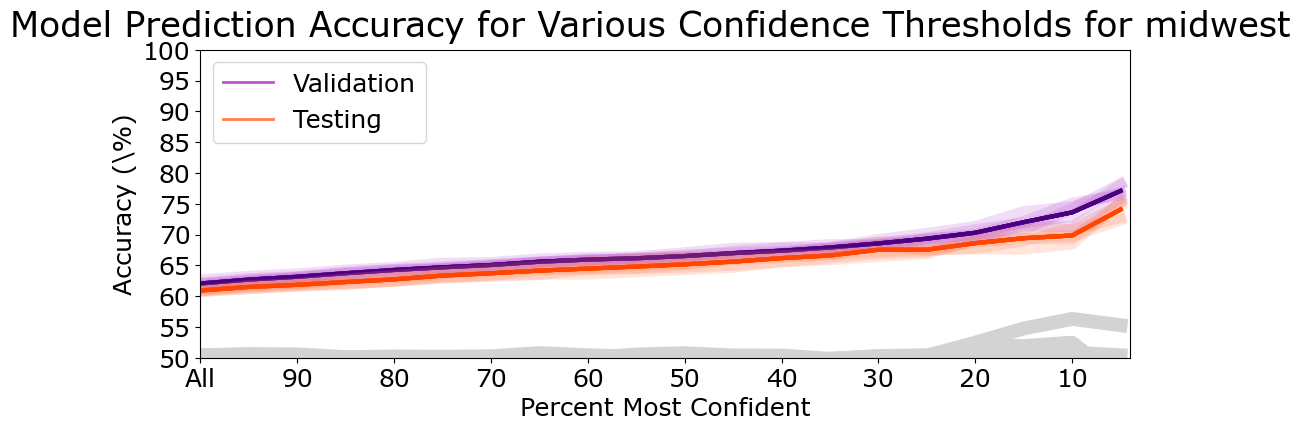

In [87]:
import matplotlib.lines as mlines

exp = 0 #choose 1 ensemble member to plot

fig, ax = plt.subplots(1,1, figsize=(12,4)) #sharex = True

for SEED in np.arange(0,5):
    ax.plot(np.arange(0,100,5), acc_val[SEED,:], color = 'mediumorchid', linewidth=8, alpha=0.2)
    ax.plot(np.arange(0,100,5), np.mean(acc_val,axis=0), color = 'indigo', linewidth=3)
    #ax.plot(np.arange(0,100,5), acc_train[SEED,:], color = 'mediumseagreen', linewidth=8, alpha=0.2)
    #ax.plot(np.arange(0,100,5), np.mean(acc_train,axis=0), color = 'darkgreen', linewidth=3)
    ax.plot(np.arange(0,100,5), acc_test[SEED,:], color = 'coral', linewidth=8, alpha=0.2)
    ax.plot(np.arange(0,100,5), np.mean(acc_test,axis=0), color = 'orangered', linewidth=3)

    ax.plot(np.arange(0,100,5), acc_untrained[SEED,:], color = 'lightgray', linewidth=10)
    ax.set(xticks=(np.arange(0,100,step=10)))
    ax.set(xlim=(0,96))
    ax.set(ylim=(50,100))
    ax.set(yticks=(np.arange(50,105, step=5)))
    ax.set(xticklabels = ['All', '90', '80', '70', '60', '50', '40', '30', '20', '10'])
    #ax.set_title('Test Ensemble Member '+str(exp),fontsize =14)
    ax.set(ylabel='Accuracy (\%)')
    ax.set(xlabel='Percent Most Confident')

labels = ['Training','Validation','Testing']            
#fig.subplots_adjust(top=0.91, wspace = 0.2, hspace = 0.6)
plt.suptitle(('Model Prediction Accuracy for Various Confidence Thresholds for '+REGION_TAND), fontsize='25')
one = mlines.Line2D([], [], color='mediumseagreen', marker='_',  label='Training')
two = mlines.Line2D([], [], color='mediumorchid', marker='_', label='Validation')
three = mlines.Line2D([], [], color='coral', marker='_', label='Testing')

plt.legend(handles=[two,three],loc='upper left',ncol=1, fontsize=18)  
#plt.savefig('/Users/marcodia/Research/lowfreq_S2S_project/figs_for_publication/acc_v_conf_'+REGION_TAND+'allexps.png', format = 'png')

## Composites

env: PYTHONHASHSEED=99


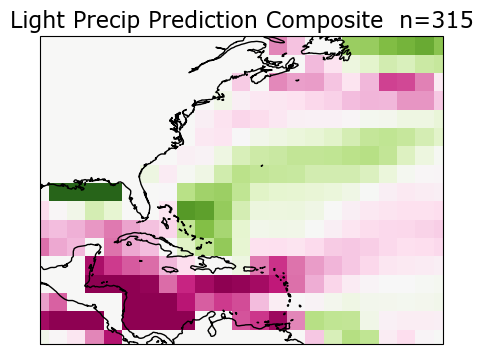

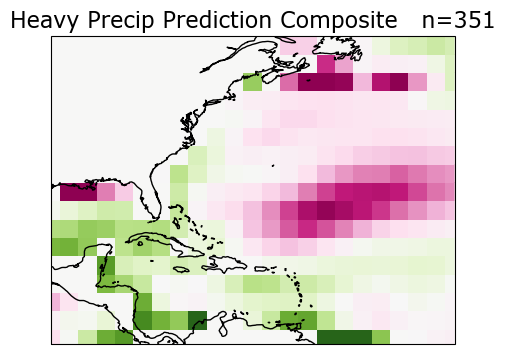

In [88]:
# ---------- X TESTING----------
X_finame1  = PREDICTOR_VAR+'_'+REGION_TOR+'_'+YEARS+'_'+'ens'+str(testing_ens)+'_dailyanom_detrend.nc'
Xtest1_full = xr.open_dataarray(ddir_X+X_finame1)
Xtest_1= Xtest1_full.where(Xtest1_full.time == TIME_ALL, drop=True)
Xtest1 = Xtest_1.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon,max_lon))

X_test1_ROLL = Xtest1.rolling(time=(rolling_input_window_X),center=False).mean()
X_test1_inputtime1 = X_test1_ROLL.where(X_test1_ROLL.time == TIME_X, drop=True)
X_test1_inputtime = X_test1_inputtime1.dropna(dim='time', how = 'all')


X_comp0 = X_test1_inputtime.where(X_test1_inputtime.time == correct_predictions0.time, drop=True)
X_comp1 = X_test1_inputtime.where(X_test1_inputtime.time == correct_predictions1.time, drop=True)


#Separate Clusters/Composites for Positive and Negative Predictions
#Clustering code adopted from github.com/eabarnes1010

# set random seed so we get identical results every time
%env PYTHONHASHSEED=99
np.random.seed(99)

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans,vq
import matplotlib.cm as cm
import matplotlib as mpl

linewidth_default = 2.0
fig_text_default = 18.
fig_title_default = fig_text_default*1.5

plt.rc('lines', linewidth=linewidth_default)    
plt.rc('text', usetex=False)
plt.rc('font', size=fig_text_default, weight='normal',family='sans-serif')
plt.rc('axes',titlesize=fig_title_default,titleweight='bold')
mpl.rcParams['figure.dpi'] = 100

#X_comp0[np.isnan(X_comp0)] = 0
X_comp0 = X_comp0.fillna(0)

data = np.array(X_comp0)
lat = Xval.lat
lon = Xval.lon

#----------- MODIFY -------------------------
numclust = 1            # number of clusters to fit
n_iters_vec = [100,]     # number of full iterations run, then take the best one
#--------------------------------------------

dist_vec = np.asarray([])
for n_iters in n_iters_vec:
    clusters, dist = kmeans(data.reshape(data.shape[0],data.shape[1]*data.shape[2]), numclust, iter=n_iters)
    classes, _ = vq(data.reshape(data.shape[0],data.shape[1]*data.shape[2]),clusters)
    dist_vec = np.append(dist_vec,dist)  

min_level = -0.1 
max_level = 0.1 
step_level = 0.001
levels = np.arange(min_level,max_level,step_level)
cmap = 'PiYG'
extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]

for cluster in np.arange(0,numclust):
    fig, (ax0) = plt.subplots(nrows=1,ncols=1, figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=200)})
    xplot = clusters[cluster,:].reshape(len(lat),len(lon))
    count = np.count_nonzero(classes == cluster)
    ax0.set_title('Light Precip Prediction Composite  n='+str(count), fontsize = '16', fontweight = 'light')
    xplot, cyclic_lons = add_cyclic_point(xplot, coord=prect_lon)
    cf0 = ax0.pcolor(cyclic_lons,lat,xplot, transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
    ax0.add_feature(cfeature.COASTLINE)
    ax0.set_extent([min_lon,max_lon,min_lat,max_lat],crs=ccrs.PlateCarree())
    #fig.colorbar(cf0,ax=ax0)

    plt.show()

#X_comp1[np.isnan(X_comp1)] = 0
X_comp1 = X_comp1.fillna(0)

data = np.array(X_comp1)


#----------- MODIFY -------------------------
numclust = 1            # number of clusters to fit
n_iters_vec = [100,]     # number of full iterations run, then take the best one
#--------------------------------------------

dist_vec = np.asarray([])
for n_iters in n_iters_vec:
    clusters, dist = kmeans(data.reshape(data.shape[0],data.shape[1]*data.shape[2]), numclust, iter=n_iters)
    classes, _ = vq(data.reshape(data.shape[0],data.shape[1]*data.shape[2]),clusters)
    dist_vec = np.append(dist_vec,dist) 

# min_level = -0.0000005 
# max_level = 0.000005 
# step_level = 0.0000005


levels = np.arange(min_level,max_level,step_level)
cmap = 'PiYG'
extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]


for cluster in np.arange(0,numclust):
    fig, (ax0) = plt.subplots(nrows=1,ncols=1, figsize=(8, 4), subplot_kw={"projection": ccrs.PlateCarree(central_longitude=200)})
    xplot = clusters[cluster,:].reshape(len(lat),len(lon))
    count = np.count_nonzero(classes == cluster)
    ax0.set_title('Heavy Precip Prediction Composite   n='+str(count), fontsize = '16', fontweight = 'light')

    xplot, cyclic_lons = add_cyclic_point(xplot, coord=prect_lon)
    cf0 = ax0.pcolor(cyclic_lons,lat,xplot, transform = ccrs.PlateCarree(), cmap =cmap,vmin = min_level, vmax=max_level)
    ax0.add_feature(cfeature.COASTLINE)
    ax0.set_extent([min_lon,max_lon,min_lat,max_lat],crs=ccrs.PlateCarree())
    #fig.colorbar(cf0,ax=ax0)
    plt.show()
